In [ ]:
# Try to load netket, and install it if the import fails
try:
    import netket as nk
except ImportError:
    !pip install --quiet --upgrade netket
    
import netket as nk
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

(Sampler)=
# The Sampler module

```{eval-rst}
.. currentmodule:: netket.sampler
```

The [Sampler](netket_sampler_api) module contains several Monte-Carlo samplers that can be used to generate samples distributed according to a certain $\log$-probability distribution function. 
The samplers defined here can be used together with the [Variational State](varstate) interface or stand-alone in your jax code. They are all fully-`jax.jit` compatible, and they can be differentiated in forward mode.

The sampler module also contains infrastructure necessary to define your own samplers that are compatible with the existing API, as well as custom transition rules for the Metropolis-Hastings sampler.

The inheritance diagram of the classes in this module is shown below:
```{eval-rst}
.. inheritance-diagram:: netket.sampler netket.sampler.rules
	:top-classes: netket.sampler.AbstractSampler
	:parts: 1

```

Following the purely functional design of Jax, we define the sampler to be a stateless collection of settings and parameters inheriting from the abstract base class {class}`Sampler`, while storing all mutable state such as the PRNG key and the statistics of acceptances in an immutable sampler state object inheriting from {class}`SamplerState`.

In the documentation below we will first discuss how to construct Monte-Carlo samplers and what are their common options, then in ... we will show how to use samplers directly so that you can use them in your own projects. 
Note that if you are using the Variational State interface, you only need to know how to define samplers, because the Variational State will take care of sampling. 

## Constructing Samplers

NetKet's samplers will generate a set of samples $\sigma$ that respects the following condition:

$$
    \sigma \in \mathcal{H} \ \ \ \ \ \vert\ \ \ \  p(\sigma) \sim \frac{\exp[\alpha\ \Re[\log\text{pdf}(\sigma)]]}{\sum_{\eta\in\mathcal{H}} \exp[\alpha\ \Re[\log\text{pdf}(\eta)]]}
$$

All NetKet samplers generate samples from an [Hilbert space](Hilbert) object, which must be passed as the first positional argument.
Other options that can be specified are:

 - The sampler's `dtype`, which is the data type used to store the arrays of samples. When working with discrete hilbert spaces such as 
{class}`nk.hilbert.Spin` and {class}`nk.hilbert.Fock` the dtype is not particularly important, and you might reduce your memory consumption by using some short 
types such as `np.int8`. By default `dtype=float64`.
When working with discrete spaces samples are usually made up of strings of integers, therefore if you use low-precision types such as `np.int8`
or `jnp.bfloat16` you will not be losing precision in the number you're representing. Moreover, as soon as you will feed the low-precision samples
to your model, it will be promoted to a wider type matching the `dtype` used for the model's parameters.

 - The sampler's `machine_power`, which is the $\alpha$ in the formula above specifying what power of the probability distribution $\text{pdf}(\sigma)$ we are sampling.

In [2]:
hilbert = nk.hilbert.Spin(0.5, 5)

sampler = nk.sampler.ExactSampler(hilbert)

print(sampler)

ExactSampler(hilbert=Spin(s=1/2, N=5), machine_pow=2, dtype=<class 'numpy.float64'>)


The sampler itself is a [_frozen dataclass_ ](https://stackoverflow.com/questions/66194804/what-does-frozen-mean-for-dataclasses), meaning that you cannot change it's attributes once it's created.
To change an attribute of the sampler, you must use the function {meth}`~SamplerState.replace` which returns a new sampler object with that setting changed.
The old sampler will be unchanged

In [3]:
new_sampler = sampler.replace(machine_pow=3)

print("this is the old one, unchanged: ", sampler)
print("this is the new one:            ", new_sampler)

this is the old one, unchanged:  ExactSampler(hilbert=Spin(s=1/2, N=5), machine_pow=2, dtype=<class 'numpy.float64'>)
this is the new one:             ExactSampler(hilbert=Spin(s=1/2, N=5), machine_pow=3, dtype=<class 'numpy.float64'>)


This (sometimes annoying) behaviour is needed to make our sampler objects completely jax-compatible. You can freely pass a NetKet sampler to a jax function and jit it without worrying!

## Using Samplers 

The core sampler's API interface is made up of 3 functions:
 - {meth}`Sampler.init_state(log_pdf, parameters, seed) <Sampler.init_state>`, which constructs a structure holding the state of the sampler with the provided seed. The seed can either be an integer or a {func}`jax.random.PRNGKey` object. When running distributed computations on different MPI nodes, this function automatically generates a different seed on every MPI node, so you do not need to take care of that (only the seed on rank 0 will be considered).
 - {meth}`Sampler.reset(log_pdf, parameters, state) <Sampler.reset>`, is a function that should be called every time the variational parameters of the log_pdf have changed, and in some cases to reset the chain. _NOTE: The state is not valid unless you call reset at least once_
 - {meth}`Sampler.sample(log_pdf, parameters, state, chain_length=1) <Sampler.sample>`, which samples a sequence of samples with `chain_length` samples. If you are using a direct sampler like {class}`ExactSampler` or {class}`ARDirectSampler` this determines how many samples you generate. If you are using a Markov-Chain sampler you will get `Sampler.n_chains * chain_length` total samples.

In general, the `log_pdf` must be a function with the signature `log_pdf(PyTree, jnp.Array[...,Sampler.hilbert.size]) -> jnp.Array[...]` or a flax Module. (Note: Some samplers such as {class}`ARDirectSampler` only work with a flax Module.)

To build an example, first we must define a log-pdf from which we want to sample. 
In this case we construct an RBM with real parameters, and initialise some random parameters which will give a roughly flat distribution:

In [4]:
# We define an Hilbert space of 3 Spin-1/2
hilbert = nk.hilbert.Spin(0.5, 4)

# We define our variational ansatz
log_pdf = nk.models.RBM(param_dtype=float)

# and we initialize it's parameters
param_seed = jax.random.key(0)

pars = log_pdf.init(param_seed, hilbert.random_state(param_seed, 3))

Now we can plot the probability distribution by computing it over the whole Hilbert space. Of course this is expensive, but if we have a small set of variables it's possible to do it.

Text(0, 0.5, 'pdf')

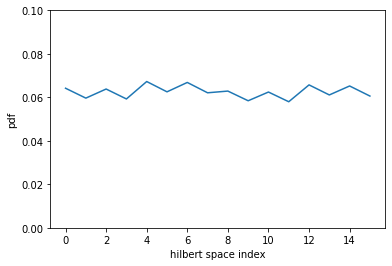

In [5]:
pdf_unnormalized = jnp.exp(2*log_pdf.apply(pars, hilbert.all_states()))
pdf = pdf_unnormalized / jnp.sum(pdf_unnormalized)

plt.plot(pdf)
plt.ylim(0,0.1)
plt.xlabel("hilbert space index")
plt.ylabel("pdf")

{class}`ExactSampler` builds exactly this same probability distribution (which has an exponentially large cost in the number of variables) and generates samples from it. 
To use it we can do:

In [6]:
# We construct an Exact Sampler
sampler = nk.sampler.ExactSampler(hilbert, dtype=jnp.int8)

# We create the state of the sampler
sampler_state = sampler.init_state(log_pdf, pars, jax.random.key(1))

# We call reset (this will pre-compute the log_pdf on the whole hilbert space)
sampler_state = sampler.reset(log_pdf, pars, sampler_state)

# generate samples
samples, sampler_state = sampler.sample(log_pdf, pars, state=sampler_state, chain_length=10)

print(f"The shape of the samples is: {samples.shape}, and the dtype is {samples.dtype}")
print(samples[0,0])

The shape of the samples is: (10, 1, 4), and the dtype is int8
[-1 -1  1  1]


Notice that samplers return a 3-tensor of samples where the first dimension is `chain_length`, the second is the number of parallel chains (or 1 in non Markov-Chain samplers such as ExactSampler) and the last dimension is the hilbert space size.

We could verify that those samples are distributed according to the correct distribution by running the following code:

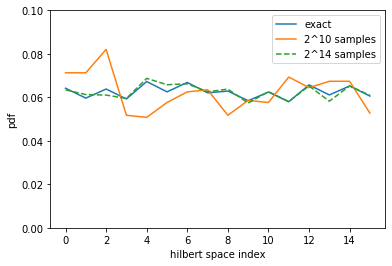

In [7]:
def estimate_pdf(n_samples):
    samples, _ = sampler.sample(log_pdf, pars, state=sampler_state, chain_length=n_samples)

    # Convert the samples to indices in the space
    idxs = hilbert.states_to_numbers(samples)

    # count the occurrences of all indices
    return jnp.sum(idxs == jnp.arange(hilbert.n_states), axis=0) / idxs.shape[0]

plt.plot(pdf, label="exact")
plt.plot(estimate_pdf(2**10), label="2^10 samples")
plt.plot(estimate_pdf(2**14), '--', label="2^14 samples")

plt.ylim(0,0.1)
plt.xlabel("hilbert space index")
plt.ylabel("pdf")
plt.legend();


## Metropolis-Hastings Markov-Chain Samplers

NetKet also implements a very flexible class of Markov Chain samplers that use the Metropolis-Hastings algorithm and is called {class}`MetropolisSampler`.
The Metropolis--Hastings algorithm is used to generate samples from an arbitrary probability distribution. 
In each step, it suggests a transition from the current configuration $s$ to a proposed configuration $s'$.
The proposal is accepted with probability

$$
    P_\text{acc}(s \rightarrow s') = \min\left( 1, \frac{P(s')}{P(s)} \frac{g(s \mid s')}{g(s' \mid s)} \right),
$$

where $P$ is the distribution being sampled from and $g(s' \mid s)$ is the conditional probability of proposing $s'$ given the current $s$. 

We call $L(s, s') = \log [g(s \mid s')/g(s' \mid s)]$ to denote the correcting factor to the log probability due to the transition kernel. 
This factor is needed for asymmetric kernels that might propose one move with higher probability than its reverse.
Simple kernels, such as a local spin flip or exchange, are symmetric, therefore $L(s,s') = L(s', s) = 1$, but other proposals, such as Hamiltonian sampling, are not necessarily symmetric and need this factor.

The transition rules (or kernels) that NetKet implements for discrete hilbert spaces are the following:
 - {class}`rules.LocalRule`: A transition rule acting on the local degree of freedom. This selects a random degree of freedom `i` and then proposes a different local configuration with uniform probability. For example, for Spin-1/2, this will flip a random spin. **Note: This transition rule ignores constraints on the hilbert space, such as total magnetization, and might produce states that do not respect it**
 - {class}`rules.ExchangeRule`: A Rule exchanging the value of the local degree of freedom between two sites $i$ and $j$, chosen from a list of
    possible couples (clusters). To construct it, the user must provide a graph object or a list of edges. **This sampler does respect constraints on Hilbert spaces, but might not explore the whole hilbert space because it preserves the total number of excitations/magnetization.**
 - {class}`rules.HamiltonianRule`: which transitions the configuration according to the off-diagonal elements of the Hamiltonian. As this rule might not be symmetric, this uses the factor $L(s,s')$ to reweight the transition probability.
 
For Continuous Hilbert spaces, the only rule that we implement (at the moment is the following:
 - {class}`rules.GaussianRule` which proposes a move by adding a normally-distributed random number to a single degree of freedom. The standard deviation of the Gaussian distribution can be modified.

The standard syntax to build a MCMC sampler with a certain rule is to pass an instance of the rule as the second argument of the Metropolis Sampler: 


In [8]:
rule = nk.sampler.rules.LocalRule()
sampler = nk.sampler.MetropolisSampler(hilbert, rule, n_chains = 10)
print(sampler)

MetropolisSampler(rule = LocalRule(), n_chains = 10, n_sweeps = 4, reset_chains = False, machine_power = 2, dtype = <class 'numpy.float64'>)


The Metropolis Sampler takes as the first two positional arguments the hilbert space to sample and the transition rule. 
Additional options that can be specified are the `dtype` and `machine_power`, like all other samplers, but also:
 - `n_chains: int` or `n_chains_per_rank:int `: The number of parallel Markov Chains to sample from. Depending on the complexity of the log-pdf and the size of the system, sampling from 1 chain or 10 might take the same time on CPU. Usually on GPUs you can sample from ~1000 of chains at the same cost of sampling from 1 chain. Only one of those 2 options can be specified at a given time, and they are equivalent when not using MPI. When using MPI, the first controls the total number of chains (and must be $>$ than the total number of MPI ranks) while the latter controls the number of chains per MPI rank. Defaults to `n_chains_per_rank=16`
 - `sweep_size: int`: The number of sub-sampling sweeps per sample. This integer controls how many Metropolis-Hastings steps are taken before returning a valid sampling. Effectively, this means that when sampling a chain of length `chain_length`, the effective chain length is `chain_length*sweep_size`, but only $1$ sample every `sweep_size` is returned. The default value is the number of degrees of freedom in the hilbert space ({attr}`AbstractHilbert.size <netket.hilbert.AbstractHilbert.size>`).
 -`reset_chains : bool`: If True, resets the chain state when `Sampler.reset` is called. By default this is `False`, meaning that during a run the chain is never completely reset (when you reset the chain, a configuration is drawn with uniform probability from the hilbert space unless a special rule is used). 

Other than those additional settings at constructions, Metropolis Samplers follow the same API as all other samplers:

In [9]:
# We create the state of the sampler
sampler_state = sampler.init_state(log_pdf, pars, jax.random.key(1))

# We call reset (this will pre-compute the log_pdf on the whole hilbert space)
sampler_state = sampler.reset(log_pdf, pars, sampler_state)

# generate samples
samples, sampler_state = sampler.sample(log_pdf, pars, state=sampler_state, chain_length=100)

print(f"The shape of the samples is: {samples.shape}, and the dtype is {samples.dtype}")
print(samples[0,0])

The shape of the samples is: (100, 10, 4), and the dtype is float64
[-1.  1. -1.  1.]


However, notice that this time the samples returned are a tensor of shape `(chain_length, n_chains_per_rank, hilbert.size)`. 

For ease of use, we provide some shorthands such as {func}`MetropolisLocal`, {func}`MetropolisHamiltonian` and so on, which automatically build the relevant rule.

## Defining custom Transition Rules for Metropolis Sampler

A transition kernel is a NetKet dataclass inheriting from {class}`rules.MetropolisRule` that must define the following two methods:

 - {meth}`MetropolisRule.init_state(self, sampler, log_pdf, params, rng) -> Optional[Any] <rules.MetropolisRule.init_state>`: which can be used to initialise some arbitrary state or cache. This will be stored inline inside of `MetropolisState`.
 - {meth}`MetropolisRule.random_state(rule, sampler, log_pdf, parameters, state, rng, σ: jnp.ndarray[n_chains, hilbert.size]) -> jnp.Array[n_chains, hilbert.size] <rules.MetropolisRule.random_state>`: this function is called when the chain is initialised or resetted, and should return a valid configuration for the Markov Chain state. The default implementation returns a state sampled with `hilbert.random_state`. 
  - {meth}`MetropolisRule.transition(rule, sampler, log_pdf, parameters, state, rng: PRNGKeyT) -> jnp.Array[n_chains, hilbert.size] <rules.MetropolisRule.transition>`: this function is called when the chain is initialised or resetted, and should return a valid configuration for the Markov Chain state. The default implementation returns a state sampled with {meth}`AbstractHilbert.random_state <netket.hilbert.AbstractHilbert.random_state>`. 
  
As an example, I will define below a custom Metropolis Transition rule that flips not one, but two spins at a time

In [10]:
@nk.utils.struct.dataclass
class TwoLocalRule(nk.sampler.rules.MetropolisRule):
    
    def transition(self, sampler, machine, parameters, state, key, σ):
        # Deduce the number of MCMC chains from input shape
        n_chains = σ.shape[0]
        
        # Load the Hilbert space of the sampler
        hilb = sampler.hilbert
        
        # Split the rng key into 2: one for each random operation
        key_indx, key_flip = jax.random.split(key, 2)
        
        # Pick two random sites on every chain
        indxs = jax.random.randint(
            key_indx, shape=(n_chains, 2), minval=0, maxval=hilb.size
        )
        
        # flip those sites
        σp, _ = nk.hilbert.random.flip_state(hilb, key_flip, σ, indxs)
        
        # If this transition had a correcting factor L, it's possible
        # to return it as a vector in the second value
        return σp, None

    #
    # random_state is inherited from the base class, so no need to define it
    #
    #def random_state(self, sampler, machine, pars, state, key):
    #    return sampler.hilbert.random_state(
    #        key, size=sampler.n_batches, dtype=sampler.dtype
    #    )


And then, in order to use this transition kernel we can follow the same procedure as before:

In [11]:
sampler = nk.sampler.MetropolisSampler(hilbert, TwoLocalRule())

In [13]:
# We create the state of the sampler
sampler_state = sampler.init_state(log_pdf, pars, jax.random.key(1))

# We call reset (this will pre-compute the log_pdf on the whole hilbert space)
sampler_state = sampler.reset(log_pdf, pars, sampler_state)

# generate samples
samples, sampler_state = sampler.sample(log_pdf, pars, state=sampler_state, chain_length=100)